 Importing the dataset from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chiaravanderlan","key":"8b60da605625c6b9e220c0b946c6b975"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

100% 327M/329M [00:04<00:00, 120MB/s]
100% 329M/329M [00:04<00:00, 81.5MB/s]


In [ ]:
!kaggle datasets download -d nizorogbezuode/rice-leaf-images

In [ ]:
!kaggle datasets download -d nizorogbezuode/rice-leaf-images

 28% 5.00M/17.7M [00:00<00:00, 49.7MB/s]
100% 17.7M/17.7M [00:00<00:00, 102MB/s] 


In [ ]:
!unzip rice-leaf-images.zip

Archive:  rice-leaf-images.zip
  inflating: rice_images/_BrownSpot/shape 1 .jpg  
  inflating: rice_images/_BrownSpot/shape 10 .jpg  
  inflating: rice_images/_BrownSpot/shape 100 .jpg  
  inflating: rice_images/_BrownSpot/shape 101 .jpg  
  inflating: rice_images/_BrownSpot/shape 102 .jpg  
  inflating: rice_images/_BrownSpot/shape 103 .jpg  
  inflating: rice_images/_BrownSpot/shape 104 .jpg  
  inflating: rice_images/_BrownSpot/shape 105 .jpg  
  inflating: rice_images/_BrownSpot/shape 106 .jpg  
  inflating: rice_images/_BrownSpot/shape 107 .jpg  
  inflating: rice_images/_BrownSpot/shape 108 .jpg  
  inflating: rice_images/_BrownSpot/shape 109 .jpg  
  inflating: rice_images/_BrownSpot/shape 11 .jpg  
  inflating: rice_images/_BrownSpot/shape 110 .jpg  
  inflating: rice_images/_BrownSpot/shape 111 .jpg  
  inflating: rice_images/_BrownSpot/shape 112 .jpg  
  inflating: rice_images/_BrownSpot/shape 113 .jpg  
  inflating: rice_images/_BrownSpot/shape 114 .jpg  
  inflating: rice_i

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3355 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['_BrownSpot', '_Healthy', '_Hispa', '_LeafBlast']

In [ ]:
len(dataset)

105

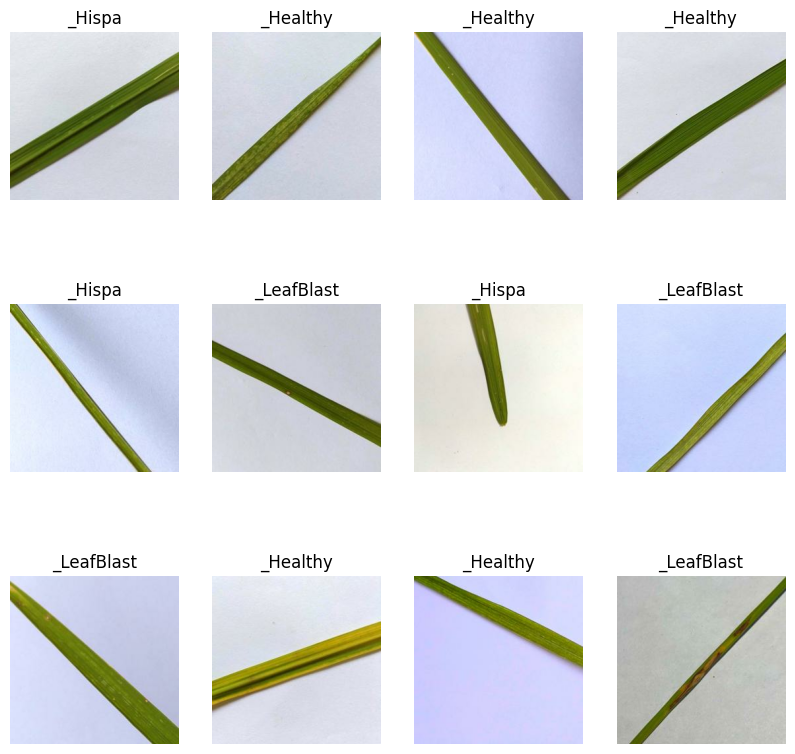

In [ ]:
plt.figure(figsize =(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
    #print(image_batch.shape)
    #print(labels_batch.numpy())

In [ ]:
len(dataset)

105

Spliting the dataset

In [ ]:
#80% ==> training
#20% ==> 10% validation ,10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

84.0

In [ ]:
train_ds = dataset.take(516)
len(train_ds)

516

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

In [ ]:
val_size=0.1
len(dataset)*val_size

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

84

In [ ]:
len(val_ds)

10

In [ ]:
len(test_ds)

11

Cache, Shuffle and prefetch

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Image preprocessing (resize and rescale)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
84/84 [==============================] - 333s 4s/step - loss: 1.2923 - accuracy: 0.4439 - val_loss: 1.3136 - val_accuracy: 0.4031
Epoch 2/10
84/84 [==============================] - 306s 4s/step - loss: 1.2831 - accuracy: 0.4461 - val_loss: 1.3173 - val_accuracy: 0.4031
Epoch 3/10
84/84 [==============================] - 300s 4s/step - loss: 1.2241 - accuracy: 0.4570 - val_loss: 1.1270 - val_accuracy: 0.5250
Epoch 4/10
84/84 [==============================] - 309s 4s/step - loss: 1.1507 - accuracy: 0.5069 - val_loss: 1.1259 - val_accuracy: 0.5219
Epoch 5/10
84/84 [==============================] - 295s 4s/step - loss: 1.1373 - accuracy: 0.5073 - val_loss: 1.1813 - val_accuracy: 0.4938
Epoch 6/10
84/84 [==============================] - 296s 4s/step - loss: 1.0966 - accuracy: 0.5218 - val_loss: 1.1083 - val_accuracy: 0.5094
Epoch 7/10
84/84 [==============================] - 294s 3s/step - loss: 1.0842 - accuracy: 0.5222 - val_loss: 1.0677 - val_accuracy: 0.5406
Epoch 8/10
84

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 19s 1s/step - loss: 1.0433 - accuracy: 0.5483


In [ ]:
scores

[1.043250560760498, 0.5482954382896423]

Plotting accuracy

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 84}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = 10

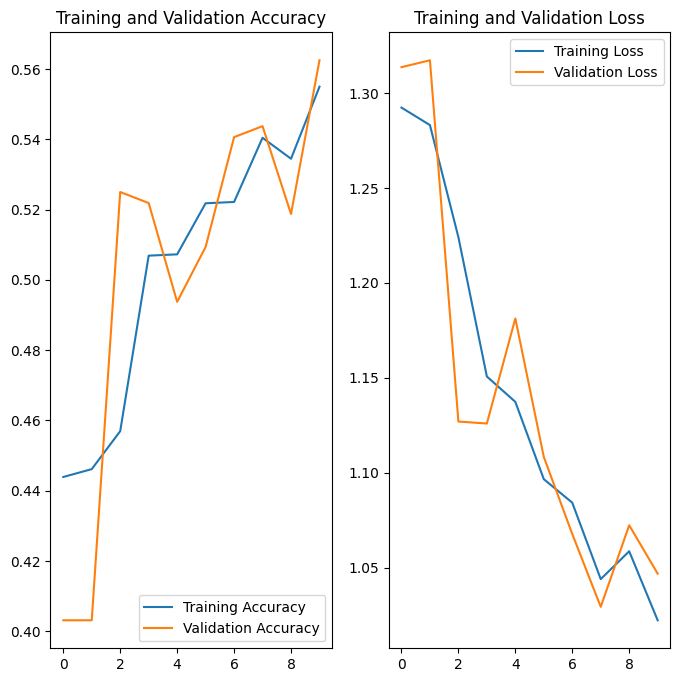

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: _BrownSpot
1/1 [==============================] - 1s 957ms/step
predicted label: _BrownSpot


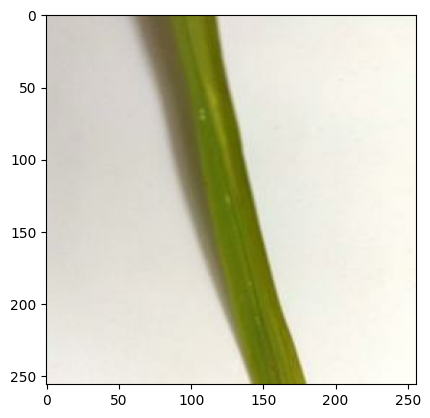

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


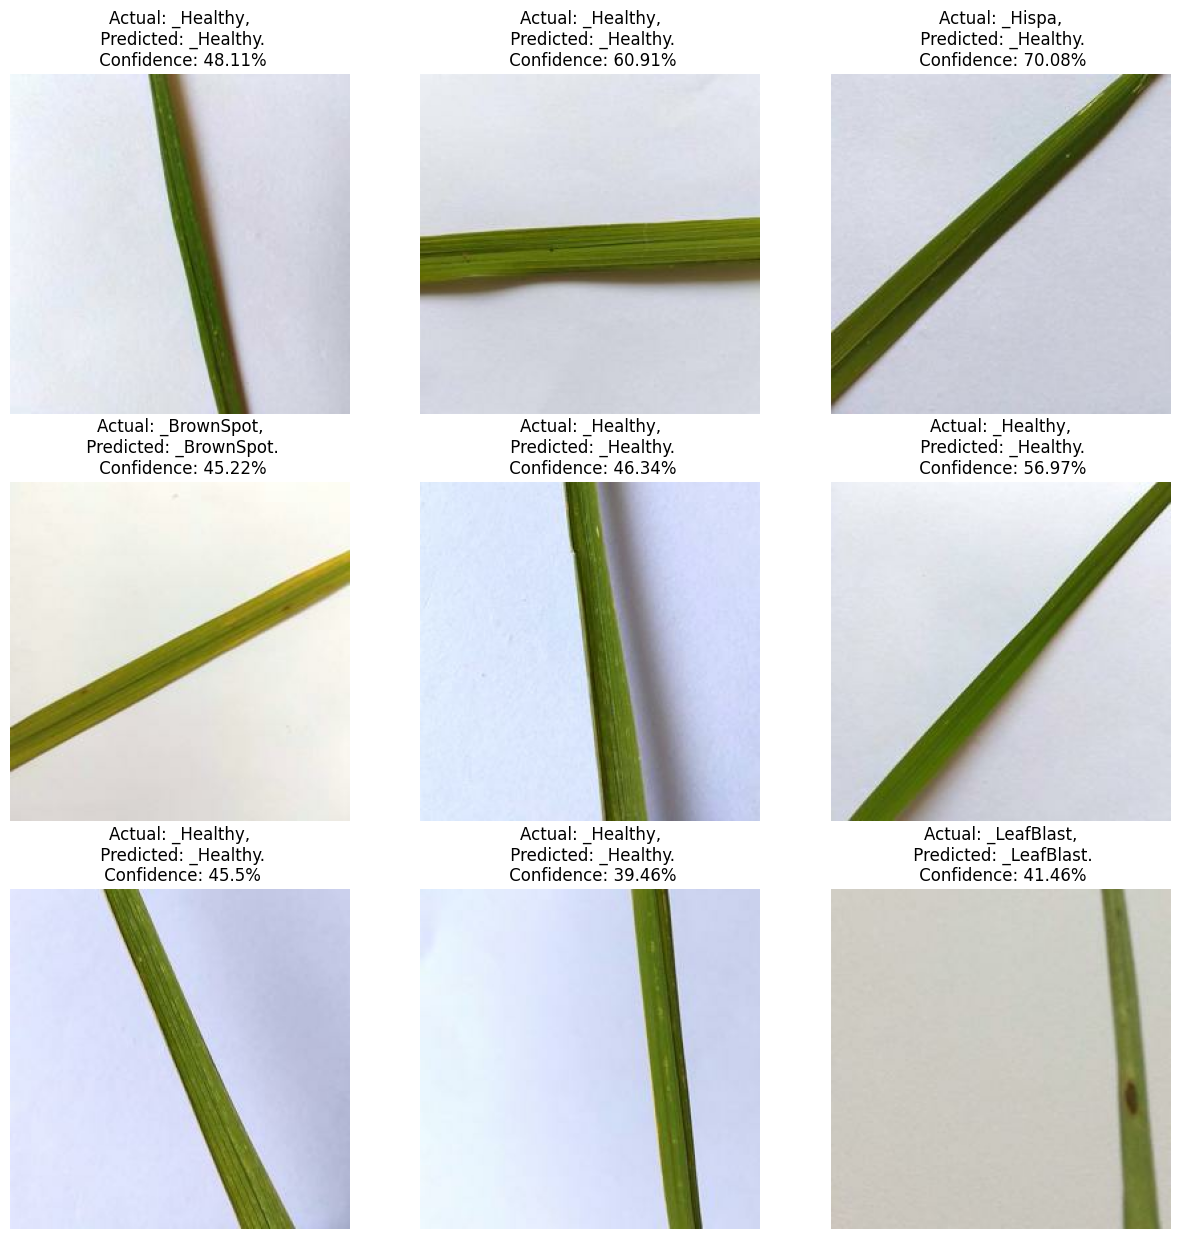

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")